In [1]:
import sys
sys.path.append('../../..')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import preprocessing
from tensorflow.keras.models import save_model,load_model
from utils.preprocessing import *
from utils.gpu.cuda_cluster import *
from utils.gpu.preprocessing import read_data, factorize_small_cardinality_with_index, df_to_tfdataset, split_join, get_media_index
from utils.evaluate import calculate_ctr, compute_rce, average_precision_score
import tensorflow.keras.backend as K
import core.config as conf

/home/nyongja/anaconda3/envs/dask/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 32979 instead
  http_address["port"], self.http_server.port


In [2]:
client

Client Scheduler: tcp://127.0.0.1:45787 Dashboard: http://127.0.0.1:32979/status,Cluster Workers: 1 Cores: 1 Memory: 33.47 GB


## Load data

In [3]:
# data_path = conf.raw_data_path + '*' # for all dataset
data_path = conf.raw_data_path + 'part-00000'
ori_df = read_data(data_path)

In [4]:
ori_df

,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,enaging_user_id,enaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,enaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
npartitions=16,,,,,,,,,,,,,,,,,,,,,,,,
1,object,object,object,object,object,object,object,object,int32,object,int32,int32,bool,int32,object,int32,int32,bool,int32,bool,int32,int32,int32,int32
273328,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2983644,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3033902,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


- media target encoding(photo, video, gif)
- tweet_type
- language
- tweet_timestamp
- engaged_with_user_id
- engaged_with_user_follower_count
- engaging_user_id
- engaging_user_following_count
- engagee_follows_engager
- 'reply_timestamp', 'retweet_timestamp','retweet_with_comment_timestamp', 'like_timestamp'

In [5]:
df = ori_df[['present_media', 'tweet_type', #'language', 'tweet_timestamp', 
             'engaged_with_user_follower_count', 
             'enaging_user_following_count', 'engagee_follows_engager','reply_timestamp', 'retweet_timestamp','retweet_with_comment_timestamp', 'like_timestamp']]

## Preprocessing

In [6]:
df['reply'] = df['reply_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['retweet'] = df['retweet_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['comment'] = df['retweet_with_comment_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)
df['like'] = df['like_timestamp'].compute().applymap(lambda x: 1 if x > 0 else 0).astype(np.int32)

In [7]:
df = df.drop('reply_timestamp', axis=1)
df = df.drop('retweet_timestamp', axis=1)
df = df.drop('retweet_with_comment_timestamp', axis=1)
df = df.drop('like_timestamp', axis=1)

In [ ]:
df.head()

## Negative Sampling

In [10]:
df_positive = df[df['like']==1]
df_negative = df[df['like']==0]
print(len(df_positive))
print(len(df_negative))

1207588
1826314


In [12]:
df_negative = df_negative.compute().sample(n = len(df_positive))

In [13]:
df = dask.dataframe.concat([df_positive, df_negative])

In [18]:
df = df.repartition(npartitions=1)
df, = dask.persist(df)
_ = wait(df)

### Media Target Encoding

In [20]:
df.head()

,present_media,tweet_type,engaged_with_user_follower_count,enaging_user_following_count,engagee_follows_engager,reply,retweet,comment,like
id,,,,,,,,,
3,<NA>,TopLevel,219715,1473,False,0,0,0,1
5,Photo,TopLevel,414,379,True,0,0,0,1
8,<NA>,Quote,209681,106,False,0,0,0,1
10,<NA>,TopLevel,881,650,False,0,0,0,1
11,<NA>,TopLevel,133933,265,False,0,0,0,1


In [21]:
df['present_media'] = df['present_media'].fillna( '' )

In [23]:
df,media_index, _ = factorize_small_cardinality_with_index(df, 'present_media', 'media_type')

In [24]:
media_index = get_media_index(media_index)

In [25]:
media_index = media_index['number_of_media'].to_frame()

In [26]:
media_index

,number_of_media
0,0
1,3
2,7
3,9
4,5
5,11
6,17
7,23
8,11
9,5


In [27]:
media_index = cudf.DataFrame(media_index)
media_index = dask_cudf.from_cudf(media_index, npartitions=2)

In [28]:
df = df.merge(media_index, left_on="media_type", right_index = True, how='left')

In [29]:
df = df.drop('present_media', axis = 1)
df = df.drop('media_type', axis = 1)

### Tweet Type Encoding

In [30]:
df, _= factorize_small_cardinality_with_index(df, 'tweet_type', 'tweet_type_encode') # how language encoding??

In [31]:
df = df.drop('tweet_type', axis = 1)

In [32]:
df.head()

,engaged_with_user_follower_count,enaging_user_following_count,engagee_follows_engager,reply,retweet,comment,like,number_of_media,tweet_type_encode
0,11955340,513,False,0,0,0,1,5,2
1,930,1172,True,0,0,0,1,0,2
2,287,715,False,0,0,0,1,0,1
3,40029,1371,False,0,0,0,1,5,2
4,286,337,True,0,0,0,1,0,1


In [33]:
df = df.astype(np.int64)

## Loss Function

In [34]:
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

## Modeling

In [36]:
df_y = df[['reply', 'retweet', 'comment', 'like']]
df_x = df.drop(['reply', 'retweet', 'comment', 'like'], axis = 1)

#### Scaling

In [37]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(df_x.compute().as_matrix())

StandardScaler()

In [38]:
ss = standard_scaler.transform(df_x.compute().as_matrix())

In [39]:
df_x = pd.DataFrame(ss, columns = df_x.columns)

In [42]:
X_train = df_x
y_train_like = df_y['like'].to_frame()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_like.compute(), test_size=0.2)

In [44]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)

In [45]:
model = Sequential([
    Dense(16, activation = 'relu', input_dim = X_test.shape[1]),
    Dense(8, activation = 'relu'),
    Dense(4, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [49]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy', # softmax : sparse_categorical_crossentropy, sigmoid : binary_crossentropy
    metrics=['binary_crossentropy'])

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                96        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 273
Trainable params: 273
Non-trainable params: 0
_________________________________________________________________


In [51]:
y_train = y_train.astype(np.float32)

In [52]:
y_val = y_val.astype(np.float32)

In [68]:
result = model.fit(
    x = X_train,
    y = y_train.to_pandas(),
    validation_data=(X_val, y_val.to_pandas()),
    epochs=20,
    batch_size=64
)

Epoch 1/20
30190/30190 [==============================] - 10s 345us/step - loss: 0.6289 - binary_crossentropy: 0.6289 - val_loss: 0.6298 - val_binary_crossentropy: 0.6298
Epoch 2/20
30190/30190 [==============================] - 11s 348us/step - loss: 0.6289 - binary_crossentropy: 0.6289 - val_loss: 0.6298 - val_binary_crossentropy: 0.6298
Epoch 3/20
30190/30190 [==============================] - 11s 348us/step - loss: 0.6288 - binary_crossentropy: 0.6288 - val_loss: 0.6295 - val_binary_crossentropy: 0.6295
Epoch 4/20
30190/30190 [==============================] - 11s 349us/step - loss: 0.6288 - binary_crossentropy: 0.6288 - val_loss: 0.6294 - val_binary_crossentropy: 0.6294
Epoch 5/20
30190/30190 [==============================] - 11s 350us/step - loss: 0.6288 - binary_crossentropy: 0.6288 - val_loss: 0.6294 - val_binary_crossentropy: 0.6294
Epoch 6/20
30190/30190 [==============================] - 11s 349us/step - loss: 0.6288 - binary_crossentropy: 0.6288 - val_loss: 0.6294 - val_bi

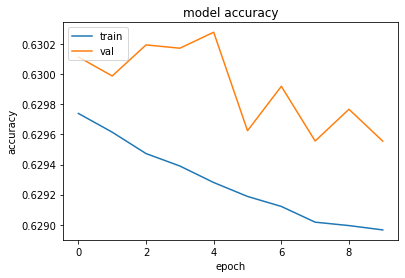

In [62]:
plt.plot(result.history['binary_crossentropy'])
plt.plot(result.history['val_binary_crossentropy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [63]:
y_test = y_test.astype(np.float32)

In [64]:
model.evaluate(X_test, y_test.to_pandas())

12076/12076 [==============================] - 3s 251us/step - loss: 0.6282 - binary_crossentropy: 0.6282


[0.6282120943069458, 0.6282120943069458]

## Predict

In [65]:
pred = model.predict(X_test)

In [66]:
rce = compute_rce(pred, y_test['like'].to_array())
rce

9.368105085871614

In [67]:
average_precision_score(y_test['like'].to_array(), pred)

0.6900809758095725

In [51]:
model_path = f'/hdd/cpu_models_DNN/model-ffnn.h5'
            
save_model(model, model_path)